In [47]:
#Important imports
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device('cpu')  

In [48]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.458,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

In [49]:
train_data=ImageFolder(r'lesson 3/training_set/training_set',transform=transformations)

In [50]:
test_data=ImageFolder(r'lesson 3/test_set/test_set',transform=transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


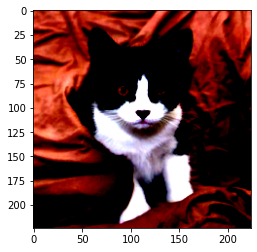

In [51]:
plt.imshow((train_data[5][0]).permute(1,2,0))

In [52]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)
        self.pool1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pool3=nn.MaxPool2d(2)
        
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(128*28*28,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,1)
        
    def forward(self,x):
        out=self.pool1(F.relu(self.conv1(x)))
        out=self.pool2(F.relu(self.conv2(out)))
        out=self.pool3(F.relu(self.conv3(out)))
        
        out=self.flatten(out)
        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=F.torch.sigmoid(self.fc3(out))
        
        return out
        
    

In [53]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        

In [54]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data,batch_size=32, shuffle=True)

In [56]:
learning_rate = 1e-3

#Initializing model with nr of features from input
model = Net().to(DEVICE)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

#Running training loop on the data with set parameters
training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

KeyboardInterrupt: 

In [ ]:
from collections import OrderedDict

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
    
nr_feat=model.fc.in_features
model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,1)),('sigmoid',nn.Sigmoid())]))
    
learning_rate = 1e-3

model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()                                                     

training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)